In [15]:
imgName = 'frame14_cmp.png'
imagOut = 'frame14_cmp_out.png'

In [16]:
#!/usr/bin/env python
# coding:UTF-8
"""LSBSteg.py

Usage:
  LSBSteg.py encode -i <input> -o <output> -f <file>
  LSBSteg.py decode -i <input> -o <output>

Options:
  -h, --help                Show this help
  --version                 Show the version
  -f,--file=<file>          File to hide
  -i,--in=<input>           Input image (carrier)
  -o,--out=<output>         Output image (or extracted file)
"""

import cv2
import docopt
import numpy as np


class SteganographyException(Exception):
    pass


class LSBSteg():
    def __init__(self, im):
        self.image = im
        self.height, self.width, self.nbchannels = im.shape
        self.size = self.width * self.height
        
        self.maskONEValues = [1,2,4,8,16,32,64,128]
        #Mask used to put one ex:1->00000001, 2->00000010 .. associated with OR bitwise
        self.maskONE = self.maskONEValues.pop(0) #Will be used to do bitwise operations
        
        self.maskZEROValues = [254,253,251,247,239,223,191,127]
        #Mak used to put zero ex:254->11111110, 253->11111101 .. associated with AND bitwise
        self.maskZERO = self.maskZEROValues.pop(0)
        
        self.curwidth = 0  # Current width position
        self.curheight = 0 # Current height position
        self.curchan = 0   # Current channel position

    def put_binary_value(self, bits): #Put the bits in the image
        for c in bits:
            val = list(self.image[self.curheight,self.curwidth]) #Get the pixel value as a list
            if int(c) == 1:
                val[self.curchan] = int(val[self.curchan]) | self.maskONE #OR with maskONE
            else:
                val[self.curchan] = int(val[self.curchan]) & self.maskZERO #AND with maskZERO
                
            self.image[self.curheight,self.curwidth] = tuple(val)
            self.next_slot() #Move "cursor" to the next space
        
    def next_slot(self):#Move to the next slot were information can be taken or put
        if self.curchan == self.nbchannels-1: #Next Space is the following channel
            self.curchan = 0
            if self.curwidth == self.width-1: #Or the first channel of the next pixel of the same line
                self.curwidth = 0
                if self.curheight == self.height-1:#Or the first channel of the first pixel of the next line
                    self.curheight = 0
                    if self.maskONE == 128: #Mask 1000000, so the last mask
                        raise SteganographyException("No available slot remaining (image filled)")
                    else: #Or instead of using the first bit start using the second and so on..
                        self.maskONE = self.maskONEValues.pop(0)
                        self.maskZERO = self.maskZEROValues.pop(0)
                else:
                    self.curheight +=1
            else:
                self.curwidth +=1
        else:
            self.curchan +=1

    def read_bit(self): #Read a single bit int the image
        val = self.image[self.curheight,self.curwidth][self.curchan]
        val = int(val) & self.maskONE
        self.next_slot()
        if val > 0:
            return "1"
        else:
            return "0"
    
    def read_byte(self):
        return self.read_bits(8)
    
    def read_bits(self, nb): #Read the given number of bits
        bits = ""
        for i in range(nb):
            bits += self.read_bit()
        return bits

    def byteValue(self, val):
        return self.binary_value(val, 8)
        
    def binary_value(self, val, bitsize): #Return the binary value of an int as a byte
        binval = bin(val)[2:]
        if len(binval) > bitsize:
            raise SteganographyException("binary value larger than the expected size")
        while len(binval) < bitsize:
            binval = "0"+binval
        return binval

    def encode_text(self, txt):
        l = len(txt)
        binl = self.binary_value(l, 16) #Length coded on 2 bytes so the text size can be up to 65536 bytes long
        self.put_binary_value(binl) #Put text length coded on 4 bytes
        for char in txt: #And put all the chars
            c = ord(char)
            self.put_binary_value(self.byteValue(c))
        return self.image
       
    def decode_text(self):
        ls = self.read_bits(16) #Read the text size in bytes
        l = int(ls,2)
        i = 0
        unhideTxt = ""
        while i < l: #Read all bytes of the text
            tmp = self.read_byte() #So one byte
            i += 1
            unhideTxt += chr(int(tmp,2)) #Every chars concatenated to str
        return unhideTxt

    def encode_image(self, imtohide):
        w = imtohide.width
        h = imtohide.height
        if self.width*self.height*self.nbchannels < w*h*imtohide.channels:
            raise SteganographyException("Carrier image not big enough to hold all the datas to steganography")
        binw = self.binary_value(w, 16) #Width coded on to byte so width up to 65536
        binh = self.binary_value(h, 16)
        self.put_binary_value(binw) #Put width
        self.put_binary_value(binh) #Put height
        for h in range(imtohide.height): #Iterate the hole image to put every pixel values
            for w in range(imtohide.width):
                for chan in range(imtohide.channels):
                    val = imtohide[h,w][chan]
                    self.put_binary_value(self.byteValue(int(val)))
        return self.image

                    
    def decode_image(self):
        width = int(self.read_bits(16),2) #Read 16bits and convert it in int
        height = int(self.read_bits(16),2)
        unhideimg = np.zeros((width,height, 3), np.uint8) #Create an image in which we will put all the pixels read
        for h in range(height):
            for w in range(width):
                for chan in range(unhideimg.channels):
                    val = list(unhideimg[h,w])
                    val[chan] = int(self.read_byte(),2) #Read the value
                    unhideimg[h,w] = tuple(val)
        return unhideimg
    
    def encode_binary(self, data):
        l = len(data)
        if self.width*self.height*self.nbchannels < l+64:
            raise SteganographyException("Carrier image not big enough to hold all the datas to steganography")
        self.put_binary_value(self.binary_value(l, 64))
        for byte in data:
            byte = byte if isinstance(byte, int) else ord(byte) # Compat py2/py3
            self.put_binary_value(self.byteValue(byte))
        return self.image

    def decode_binary(self):
        l = int(self.read_bits(64), 2)
        output = b""
        for i in range(l):
            output += chr(int(self.read_byte(),2)).encode("utf-8")
        return output


def main():

    steg = LSBSteg(cv2.imread(imgName))
    data = open("requirements_8kb.txt", "r").read()
    img_encoded = steg.encode_text(data)
#     imgname = 'frame' + str(i) + '_out.png'
    cv2.imwrite(imagOut, img_encoded)

#decoding
#     for i in range(0, 98):
    imgname = imagOut
    im = cv2.imread(imgname)
    steg = LSBSteg(im)
    raw = steg.decode_text()
    print("Text value:", raw)
    with open("secret.txt", "w") as f:
        f.write(raw)
            


if __name__=="__main__":
    main()



Text value: he Delhi High Court has directed the Delhi Police Commissioner to immediately suspend the accused police officials in the incident which took place outside Tis Hazari Court on Saturday.

Further action will also be taken by the Commissioner as an independent commission for internal enquiry has already been formed.

The Delhi Police Commissioner will complete the internal enquiry within six weeks and submit the report to the court.

The Delhi Police on Sunday told the high court that a special investigation team has been formed to look into the clash between lawyers and police at Tis Hazari court.

What happened?

Lawyers and police had clashed at Tis Hazari Court complex in New Delhi on Saturday afternoon during which at least 20 police personnel and several lawyers were injured while 17 vehicles vandalised, according to officials and eyewitnesses.

Two station house officers (SHOs) and an additional commissioner were among the 20 personnel injured, police said and claimed 

True

In [5]:
quantization_table = [[16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [68, 56, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]]


def dct(image):
    image_data = image.astype(float)
    m, n = image_data.shape
    image_dct = np.zeros(image.shape)
    x_division = int(m/8)
    y_division = int(n/8)
#     print ('m = ', m)
#     print ('n = ', n)
#     print (x_division)
#     print (y_division)
    
    lis_dct = []
    x = 0
    F = 0
    lis_F = []
    TF = 0.1
    lis_selected = []
    
    T = 0.2
    TL = 0.2
    TH = 0.3
    
    pointer = 0
    
    avg = 0
    
    eof = 0
    
    a = 0
    
#     f = open("Data.txt","r")
#     string = f.read()
#     print (string)
    
#     data = ''
#     for i in string:
#         data += convert(i)
#     print (string)
#     print (data)
    finalSum = 0

    for i in range(0, x_division):
        for j in range(0, y_division):
            x_s = i * 8
            x_e = (i+1) * 8
            y_s = j * 8
            y_e = (j+1) * 8
            image_dct[x_s:x_e, y_s:y_e] = cv2.dct(image_data[x_s:x_e,y_s:y_e]) / quantization_table
            lis_dct = cv2.dct(image_data[x_s:x_e,y_s:y_e]) / quantization_table
            y = 0
            sum_coeff = 0
            avg = 0
            
            if eof == 0:
            
                for l in lis_dct:
                    for k in l:
                        if y == 0:
                            y += 1
                            continue
                        else:
                            y += 1
                            sum_coeff += (k * k)
                            avg += k
    #             print ('sum_coeff = ', sum_coeff)
                finalSum += sum_coeff
#                 F = sum_coeff/64
#                 avg /= 64
                
#                 lis_F.append(F)


#     print ("Avg is ", sum(lis_F) / len(lis_F))
#     print (lis_F)
#     print (data)
#     print ("Length of lis_F = ", len(lis_F))
#     print ("Length of lis_selected = ", len(lis_selected))
#     print (lis_selected)
    return (finalSum/(360*480))
#     return image_dct

In [6]:
print (dct(cv2.imread('frame14_outt.png', 0)))
print (dct(cv2.imread('frame14.png', 0)))

4.458159309089669
4.458157705727141


In [12]:
maxF = -1
maxFile = -1
for i in range(0, 98):
    imgname = 'frame' + str(i) + '.png'
    image = cv2.imread(imgname, 0)
    Fval = dct(image)
#     print (Fval, i)
    if maxF < Fval:
        maxF = Fval
        maxFile = i
image = cv2.imread(imgName, 0)
Fval = dct(image)
print (maxF, maxFile)
# print(Fval)

4.458157705727141 14


In [14]:
# Testing Compressed file

imgname = 'frame14_cmp.png'
image = cv2.imread(imgname, 0)
Fval = dct(image)
print(Fval)

4.457911781496392


In [10]:
import numpy, math

def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    rmse = numpy.sqrt(mse)
    print(mse, rmse)
    if mse == 0:
        print ("same")
        return 100
    
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [26]:
image = cv2.imread(imgName, 0)
image_dct = cv2.imread("frame14_cmp_mt_8kb.png", 0)

print (psnr(image, image_dct))

# image = cv2.imread('frame96.png', 0)
# image_dct = cv2.imread('frame96_outt.png', 0)

# print (psnr(image, image_dct))


# image = cv2.imread('frame96.png', 0)
# image_dct = cv2.imread('frame96_out.png', 0)

# print (psnr(image, image_dct))

# image = cv2.imread('frame14_cmp.png', 0)
# image_dct = cv2.imread('frame14_cmp_out.png', 0)

# print (psnr(image, image_dct))


# image = cv2.imread('frame14_cmp.png', 0)
# image_dct = cv2.imread('frame14_cmp_outt.png', 0)

# print (psnr(image, image_dct))


# image = cv2.imread('frame14.png', 0)
# image_dct = cv2.imread('frame14_outt2.png', 0)

# print (psnr(image, image_dct))


# image = cv2.imread('frame14_cmp.png', 0)
# image_dct = cv2.imread('frame14_outt2.png', 0)

# print (psnr(image, image_dct))

0.4859201388888889 0.6970797220468322
51.26515462160798


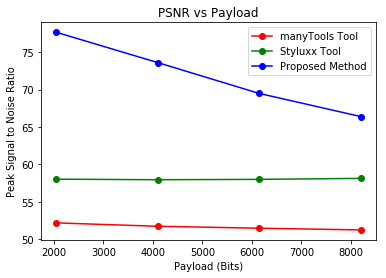

In [6]:
# PSNR Vs Payload

import matplotlib.pyplot as plt 
  
# y axis values 
y_mt = [52.204, 51.751, 51.493, 51.265] 
# corresponding x axis values 
x_mt = [2048,4096,6144,8192] 
plt.plot(x_mt, y_mt, label = "manyTools Tool",  marker='o', color='r') 


# y axis values 
y_styluxx = [58.038, 57.964, 58.013, 58.144] 
# corresponding x axis values 
x_styluxx = [2048,4096,6144,8192] 
plt.plot(x_styluxx, y_styluxx, label = "Styluxx Tool",  marker='o', color='g') 

# y axis values 
y = [77.650, 73.604, 69.485, 66.403] 
# corresponding x axis values 
x = [2048,4096,6144,8192] 
plt.plot(x, y, label = "Proposed Method",  marker='o', color='b') 


# # plotting the points  
# plt.plot(x, y) 
  
# naming the x axis 
plt.xlabel('Payload (Bits)') 
# naming the y axis 
plt.ylabel('Peak Signal to Noise Ratio') 
  
# giving a title to my graph 
plt.title('PSNR vs Payload') 
         
# show a legend on the plot 
plt.legend() 
# function to show the plot 
plt.show() 

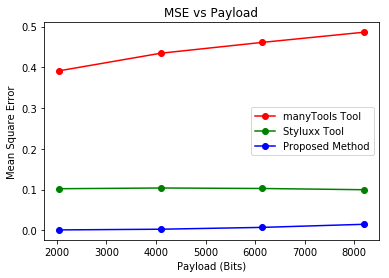

In [8]:
# MSE Vs Payload
  
# y axis values 
y_mt = [0.39140, 0.43446, 0.46101, 0.48592] 
# corresponding x axis values 
x_mt = [2048,4096,6144,8192] 
plt.plot(x_mt, y_mt, label = "manyTools Tool",  marker='o', color='r') 


# y axis values 
y_styluxx = [0.10215, 0.10391, 0.10273, 0.09969] 
# corresponding x axis values 
x_styluxx = [2048,4096,6144,8192] 
plt.plot(x_styluxx, y_styluxx, label = "Styluxx Tool",  marker='o', color='g') 

# y axis values 
y = [0.00111 , 0.002835, 0.00732, 0.01488] 
# corresponding x axis values 
x = [2048,4096,6144,8192] 
plt.plot(x, y, label = "Proposed Method",  marker='o', color='b') 


# # plotting the points  
# plt.plot(x, y) 
  
# naming the x axis 
plt.xlabel('Payload (Bits)') 
# naming the y axis 
plt.ylabel('Mean Square Error') 
  
# giving a title to my graph 
plt.title('MSE vs Payload') 
         
# show a legend on the plot 
plt.legend() 
# function to show the plot 
plt.show() 

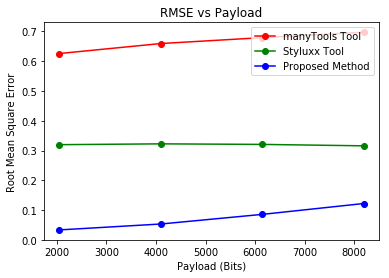

In [7]:
# RMSE Vs Payload
  
# y axis values 
y_mt = [0.62562, 0.65913, 0.67897, 0.69707] 
# corresponding x axis values 
x_mt = [2048,4096,6144,8192] 
plt.plot(x_mt, y_mt, label = "manyTools Tool",  marker='o', color='r') 


# y axis values 
y_styluxx = [0.31962, 0.32235, 0.32052, 0.31574] 
# corresponding x axis values 
x_styluxx = [2048,4096,6144,8192] 
plt.plot(x_styluxx, y_styluxx, label = "Styluxx Tool",  marker='o', color='g') 

# y axis values 
y = [0.03342 , 0.05325, 0.08556, 0.12200] 
# corresponding x axis values 
x = [2048,4096,6144,8192] 
plt.plot(x, y, label = "Proposed Method",  marker='o', color='b') 


# # plotting the points  
# plt.plot(x, y) 
  
# naming the x axis 
plt.xlabel('Payload (Bits)') 
# naming the y axis 
plt.ylabel('Root Mean Square Error') 
  
# giving a title to my graph 
plt.title('RMSE vs Payload') 
         
# show a legend on the plot 
plt.legend() 
# function to show the plot 
plt.show() 

In [88]:
img = cv2.imread('frame0.png', 0)      # 1 chan, grayscale!
imf = np.float32(img)/255.0  # float conversion/scale
dst = cv2.dct(imf)
cv2.imwrite('frame0dct.png', dst)

True